The purpose of this notebook is to experiment with Neural ODEs to see why they are useful. Neural ODEs are an extension of Resnets that can use numerical ode solvers to solve a neural network. But why is this useful from a scientific modeling stand point? If either way, we have to solve the ODE (the exact vs or the parametrized rhs).

Here we try to answer that.

**Note: This notebook will not run for you unless you have my two forks of torchdyn and torchdiffeq installed on the `scipy_info` branch for both**

https://github.com/ChrisDeGrendele/torchdiffeq/tree/scipy_info

https://github.com/ChrisDeGrendele/torchdyn/tree/scipy_info


In [1]:
!pip install -e ../../torchdyn/
!pip install -e ../../git_tmp/torchdiffeq/

Obtaining file:///Users/chris/Desktop/torchdyn
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


  Attempting uninstall: torchdyn
    Found existing installation: torchdyn 0.2.2.2.dev36+ge7428e6.d20210427
    Uninstalling torchdyn-0.2.2.2.dev36+ge7428e6.d20210427:
      Successfully uninstalled torchdyn-0.2.2.2.dev36+ge7428e6.d20210427
  Running setup.py develop for torchdyn
Obtaining file:///Users/chris/Desktop/git_tmp/torchdiffeq
  Attempting uninstall: torchdiffeq
    Found existing installation: torchdiffeq 0.2.1
    Uninstalling torchdiffeq-0.2.1:
      Successfully uninstalled torchdiffeq-0.2.1
  Running setup.py develop for torchdiffeq


In [2]:
import torch
import torchdiffeq as node
import scipy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torchdyn
import torch.utils.data as data
import torch.nn as nn
import pytorch_lightning as pl
#from torchdyn.models import *
#from torchdyn import *
import time
import torchdyn

#udot = f(u,t )

We'll start with Beta-Decay

$$\dot{X}_0 (t) = - A \cdot X_0 (t)$$
$$\dot{X}_1 (t) = - A \cdot (1-X_0) (t)$$




In [3]:
class odefunc(torch.nn.Module):
    def __init__(self, sys):
        super().__init__()
        self.sys = sys
    def forward(self, x):
        return self.sys(x)
    
#Beta Decay (system of equations to learn!)
A = 1 #for now
def sys(x):
    dx1dt =  -A * x[:,0]
    dx2dt =  A * (1- x[:,0])
    return torch.cat([dx1dt[:,None], dx2dt[:,None]], 1)



def test_model(f):
    '''Trains a model with the given neural network architecture.
    It will then return the error between the exact vector field solved numerically
    and the trained vector field solved numerically. 
    It will also return the time it took to evalaute the two.'''
    


    class Learner(pl.LightningModule):
        def __init__(self, model:nn.Module):
            super().__init__()
            self.model = model

        def forward(self, x):
            return self.model(x)

        def loss(self, y, y_hat):
            return ((y-y_hat)**2).sum(1).mean()


        def training_step(self, batch, batch_idx):
            x = torch.randn(2048,2)
            y = vf(x)
            y_hat = self.model.defunc(0,x)
            loss = self.loss(y_hat, y)
            logs = {'train_loss': loss}
            return {'loss': loss, 'log': logs}


        def configure_optimizers(self):
            return torch.optim.Adam(self.model.parameters(), lr=0.005)

        def train_dataloader(self):
            return trainloader


    system = torchdyn.NeuralDE(odefunc(sys), sensitivity='adjoint', solver = "scipy_Radau")

    x0_0 = torch.abs(torch.rand(1000,1)) #0,1
    x1_0 = 1-x0_0  #other species must add to get 1.
    x0 = torch.cat((x0_0, x1_0), 1)


    t_span = torch.linspace(0,10,100)
    #Now lets's create a data set to train on.


    vf = odefunc(sys) #creates a function 

    X = 4*torch.rand(2048,2) #grid of x data points 
    y = vf(X) #evaluated on our field y.

    train = data.TensorDataset(X, y)
    trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)



    model = torchdyn.NeuralDE(f, order=1,sensitivity='adjoint', solver='scipy_Radau')
    num_pam = pytorch_total_params = sum(p.numel() for p in model.parameters())

    learn = Learner(model)
    trainer = pl.Trainer(min_epochs=200, max_epochs=300)
    trainer.fit(learn)

    #testing
    x0_0 = torch.abs(torch.rand(1000,1)) #0,1
    x1_0 = 1-x0_0  #other species must add to get 1.
    x0 = torch.cat((x0_0, x1_0), 1)

    t_span = torch.linspace(0, 20, 100) #this is twice as long as what waas trained on



    tic = time.perf_counter()
    #vector field evaulated exactly numerically solved
    #ex_traj = model.trajectory(x0, t_span)
    ex_traj, ex_info = model.trajectory(x0, t_span, info=True)

    toc = time.perf_counter()
    exact_field_time = toc - tic


    tic = time.perf_counter()
    
    #trained vector field to be numerically solved
    #nn_traj = system.trajectory(x0, t_span) 
    nn_traj, nn_info = system.trajectory(x0, t_span, info=True)
    toc = time.perf_counter()
    nn_field_time = toc - tic


    #compute a least squared like error. 
    mseloss = nn.MSELoss() 
    err = 0
    for i in range(ex_traj.size()[1]): #loop over trajectories
        lossx = mseloss(ex_traj[:, i, 0], nn_traj[:, i, 0]) #MSE of x points in each trajectory
        lossy = mseloss(ex_traj[:, i, 1], nn_traj[:, i, 1]) 

        err +=  lossx**2 + lossy**2
    err = torch.sqrt(err)      
    
    
    '''
    err -> MSE (MSE(actualx, computedx), MSE(actualy), computedy))
    exact_field_time -> time to integrate exact rhs
    nn_field_time -> time to integrate parametrized rhs
    num_pam -> number of trainable parameters in NN
    ex_info -> scipy info object for exact integration
    nn_info -> scipy info object for nn integration
    '''
    
    return err, exact_field_time, ex_info, nn_field_time, nn_info, num_pam

In [4]:
nn1 = nn.Sequential(
                  nn.Linear(2,16),
                  nn.Tanh(),
                  nn.Linear(16,16),
                  nn.Tanh(),
                  nn.Linear(16, 2)
                )

nn2 = nn.Sequential(
                  nn.Linear(2,16),
                  nn.Tanh(),
                  nn.Linear(16,16),
                  nn.Tanh(),
                  nn.Linear(16,16),
                  nn.Tanh(),
                  nn.Linear(16, 2)
                )

nn3 = nn.Sequential(
                  nn.Linear(2,8),
                  nn.Tanh(),
                  nn.Linear(8,8),
                  nn.Tanh(),
                  nn.Linear(8,8),
                  nn.Tanh(),
                  nn.Linear(8, 2)
                )

nn4 = nn.Sequential(
                  nn.Linear(2,8),
                  nn.Tanh(),
                  nn.Linear(8,8),
                  nn.Tanh(),
                  nn.Linear(8, 2)
                )
'''
nn5 = nn.Sequential(
          nn.Conv1d(2,8,4),
          nn.ReLU(),
          nn.Conv1d(8,16, 12),
          nn.ReLU(),
          nn.Linear(16, 2)
        )
'''
networks = [nn4, nn3, nn1, nn2]

/Users/chris/Desktop/torchdyn/torchdyn/models/neuralde.py:113: UserWarning: CUDA is not available with SciPy solvers.
  warnings.warn(UserWarning("CUDA is not available with SciPy solvers."))
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 114   
------------------------------------
114       Trainable params
0         Non-trainable params
114       Total params
0.000     Total estimated model params size (MB)
/Users/chris/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/chris/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


/Users/chris/Desktop/torchdyn/torchdyn/models/neuralde.py:113: UserWarning: CUDA is not available with SciPy solvers.
  warnings.warn(UserWarning("CUDA is not available with SciPy solvers."))
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 186   
------------------------------------
186       Trainable params
0         Non-trainable params
186       Total params
0.001     Total estimated model params size (MB)


---Neural Network of size:  114
Exact: 
 - RHS Evaluations:  399
 - Jacobian Evaluations:  21
 - LU Decompositions:  82
NN: 
 - RHS Evaluations:  204
 - Jacobian Evaluations:  6
 - LU Decompositions:  48


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 354   
------------------------------------
354       Trainable params
0         Non-trainable params
354       Total params
0.001     Total estimated model params size (MB)


---Neural Network of size:  186
Exact: 
 - RHS Evaluations:  466
 - Jacobian Evaluations:  23
 - LU Decompositions:  106
NN: 
 - RHS Evaluations:  166
 - Jacobian Evaluations:  6
 - LU Decompositions:  38


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 626   
------------------------------------
626       Trainable params
0         Non-trainable params
626       Total params
0.003     Total estimated model params size (MB)


---Neural Network of size:  354
Exact: 
 - RHS Evaluations:  527
 - Jacobian Evaluations:  27
 - LU Decompositions:  126
NN: 
 - RHS Evaluations:  125
 - Jacobian Evaluations:  5
 - LU Decompositions:  26



---Neural Network of size:  626
Exact: 
 - RHS Evaluations:  429
 - Jacobian Evaluations:  21
 - LU Decompositions:  106
NN: 
 - RHS Evaluations:  169
 - Jacobian Evaluations:  7
 - LU Decompositions:  40


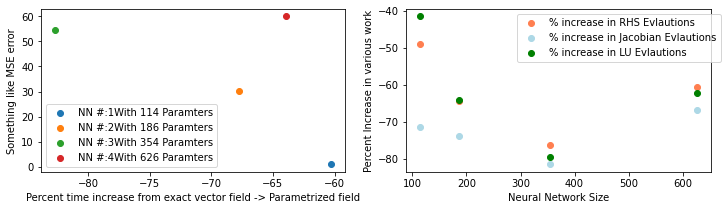

In [5]:
i = 1
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,3))

for net in networks:
    err, te, einfo, tn, ninfo, numpam = test_model(net)
    
    
    err = err.detach().numpy()

    ax1.scatter((tn-te)/te * 100, err, label = "NN #:" + str(i) + "With " + str(numpam) + " Paramters")
    
    print("---Neural Network of size: ", numpam)
    print("Exact: ")
    print(" - RHS Evaluations: ", einfo.nfev)
    print(" - Jacobian Evaluations: ", einfo.njev)
    print(" - LU Decompositions: ", einfo.nlu)
    print("NN: ")
    print(" - RHS Evaluations: ", ninfo.nfev)
    print(" - Jacobian Evaluations: ", ninfo.njev)
    print(" - LU Decompositions: ", ninfo.nlu)

    ax2.scatter(numpam, 100*(ninfo.nfev-einfo.nfev)/einfo.nfev, c ='coral', label='% increase in RHS Evlautions')
    ax2.scatter(numpam, 100*(ninfo.njev-einfo.njev)/einfo.njev, c='lightblue', label='% increase in Jacobian Evlautions')
    ax2.scatter(numpam, 100*(ninfo.nlu-einfo.nlu)/einfo.nlu, c='green', label='% increase in LU Evlautions')
    if i == 1:
        ax2.legend(bbox_to_anchor=(1.05, 1))
    i += 1
ax1.legend()
ax1.set_xlabel('Percent time increase from exact vector field -> Parametrized field')
ax1.set_ylabel('Something like MSE error')
ax2.set_xlabel("Neural Network Size")
ax2.set_ylabel("Percent Increase in various work");